# PyGIMLi - DCIP (real dataset)

Using the DCIP (Direct Current, Induced Polarization) solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve problem with a real dataset.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_dcip/pygimli_dcip_century_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Note: This notebook is adapted from a SimPEG example authored by Lindsey Heagy and presented at Transform 2020. [Original Materials](https://curvenote.com/@simpeg/transform-2020-simpeg-tutorial/!6DDumb03Le6D8N8xuJNs)

## 0. Set up environment

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

We will need the following packages:

- `os` to list and load dataset
- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pygimli
import cofi

## 1. Load the data

We will need to download the preprocessed dataset first. This notebook [century_data_preprocessing.ipynb](century_data_preprocessing.ipynb) contains the code for data preprocessing.

In [ ]:
os.listdir('century')

['27750N',
 '46800E',
 '46200E',
 'gmt',
 '47200E',
 '47000E',
 '47700E',
 'geologic_section.csv',
 'Data_in_3D_format']

In [ ]:
line = "46800E"
print(os.listdir(os.path.join('century',line)))

dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

['46800IP.OBS', 'IPMODA.CHG', '468MESH.DAT', '46800POT.OBS', '.ipynb_checkpoints', 'DCMODA.CON', 'IPMODA.PRE', 'DCMODA.PRE']


In [ ]:
def read_dcip_data(filename, verbose=True):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    verbose: bool
        Print some things? 
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype=str)
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    
    if verbose is True: 
        print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = []
    b_locations = []
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_loc = float(a_location)
        b_loc = float(b_location)
        nrx = int(nrx)

        if verbose is True: 
            print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        # m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        # observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_loc = float(m_location)
            n_loc = float(n_location)
            dt = float(datum)
            std = float(std)
            
            # append sources (a, b), receivers (m, n), datum and std
            a_locations.append(a_loc)
            b_locations.append(b_loc)
            m_locations.append(m_loc)
            n_locations.append(n_loc)
            observed_data.append(dt)
            standard_deviations.append(std)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

In [7]:
dc_data_dict = read_dcip_data(dc_data_file)

number of sources: 27
Source 0: A-loc: 26000.000000, B-loc: 26100.000000, N receivers: 2
Source 1: A-loc: 26100.000000, B-loc: 26200.000000, N receivers: 3
Source 2: A-loc: 26200.000000, B-loc: 26300.000000, N receivers: 4
Source 3: A-loc: 26300.000000, B-loc: 26400.000000, N receivers: 5
Source 4: A-loc: 26400.000000, B-loc: 26500.000000, N receivers: 6
Source 5: A-loc: 26500.000000, B-loc: 26600.000000, N receivers: 7
Source 6: A-loc: 26600.000000, B-loc: 26700.000000, N receivers: 7
Source 7: A-loc: 26700.000000, B-loc: 26800.000000, N receivers: 6
Source 8: A-loc: 26800.000000, B-loc: 26900.000000, N receivers: 6
Source 9: A-loc: 26900.000000, B-loc: 27000.000000, N receivers: 6
Source 10: A-loc: 27000.000000, B-loc: 27100.000000, N receivers: 6
Source 11: A-loc: 27100.000000, B-loc: 27200.000000, N receivers: 6
Source 12: A-loc: 27200.000000, B-loc: 27300.000000, N receivers: 6
Source 13: A-loc: 27300.000000, B-loc: 27400.000000, N receivers: 6
Source 14: A-loc: 27400.000000, B-lo

In [8]:
dc_data_file

'./century/46800E/46800POT.OBS'

In [90]:
len(dc_data_dict["a_locations"])

151

In [95]:
for key, value in dc_data_dict.items():
    if key == "n_sources":
        print(f"{key:<20}: {type(value)}")
    else:
        print(f"{key:<20}: {type(value)} (length: {len(value)})")

a_locations         : <class 'list'> (length: 151)
b_locations         : <class 'list'> (length: 151)
m_locations         : <class 'list'> (length: 151)
n_locations         : <class 'list'> (length: 151)
observed_data       : <class 'list'> (length: 151)
standard_deviations : <class 'list'> (length: 151)
n_sources           : <class 'int'>


In [96]:
location_start = np.min(dc_data_dict["a_locations"])
location_stop = np.max(dc_data_dict["n_locations"])
location_interval = 100
location_num = int((location_stop - location_start) / location_interval + 1)

## Step 2: Create a PyGIMLi measuring scheme

In [211]:
scheme = pygimli.DataContainerERT()

for sensor in np.linspace(location_start, location_stop, location_num):
    scheme.createSensor((sensor, 0.0, 0.0))

locs_sources = np.vstack((dc_data_dict["a_locations"], dc_data_dict["b_locations"])).T
locs_receivers = np.vstack((dc_data_dict["m_locations"], dc_data_dict["n_locations"])).T
for i in range(len(locs_sources)):
    src = locs_sources[i]
    src_idx = (src - location_start) / location_interval
    rec = locs_receivers[i]
    rec_idx = (rec - location_start) / location_interval
    scheme.createFourPointData(i, src_idx[0], src_idx[1], rec_idx[0], rec_idx[1])
scheme

Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'm', 'n', 'valid']

In [212]:
scheme["rhoa"] = dc_data_dict["observed_data"]
scheme["err"] = dc_data_dict["standard_deviations"]

In [213]:
scheme

Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'err', 'm', 'n', 'rhoa', 'valid']

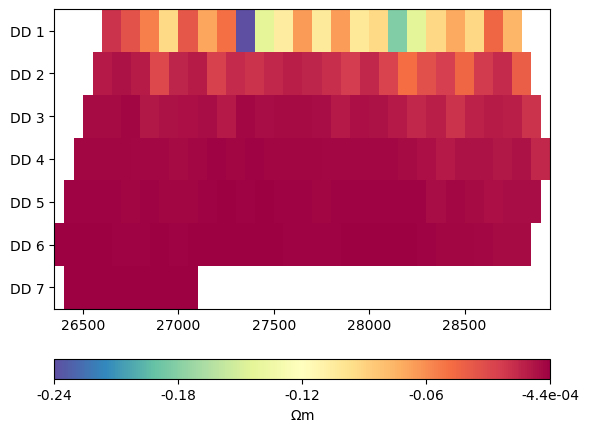

In [214]:
def plot_data(scheme, data_vals, title):
    pygimli.physics.ert.showERTData(scheme, vals=data_vals, label=r"$\Omega$m")

plot_data(scheme, scheme["rhoa"], "test")
# scheme["rhoa"]